# Introduction

Welcome to Module 2 of the Text Mining Track! This module will explore exploratory analysis of text data. With a text preprocessing skill we learned in Module 1, we will build a dataset and explore the basic characteristics of the dataset. You will do so through a combination of video lectures, interactive notebooks, and hands-on coding exercises.

Lets begin!

## How to Run the Module

Throughout this module you will encounter both text and code cells. Please run each cell in this Notebook by clicking "Run" button in the Toolbar or by pushing Shift+Enter keys
<br>
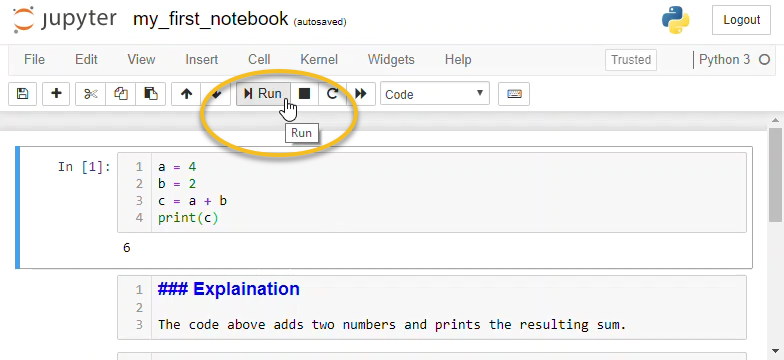

The cell below is an example of a code cell. You will be running numerous code cells like the one below throughout the case. Select the cell and select the run button above. 

In [ ]:
# This is an example of a code cell
print('Congratulations!')
print('You\'ve run your first code cell.')

## Introduction Video

**Please run the code cell below to reveal the video.**

In [ ]:
# Set Up
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import HTML

# Display Video
HTML('<iframe width="705" height="537" src="https://edpuzzle.com/embed/media/5ec58e1b7e9be63ef5a3d5de" frameborder="0" allowfullscreen></iframe>')

The data is a publicly available, annotated dataset that was previously curated manually by systematic reviewers.  
*Sources: Cohen AM et al. Reducing Workload in Systematic Review Preparation Using Automated Citation Classification.* JAMIA *2006;13(2):206-219. Downloaded from https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html on March 26, 2020*

Systematic review decisions for abstracts and articles are included for these fifteen drug review topics:  
- ACE inhibitors (ACEIs)  
- Attention-deficit hyperactivity disorder (ADHD)  
- Antihistamines
- Atypical antipsychotics  
- Beta blockers (BBs)
- Calcium challen blockers (CCBs)  
- Estrogens  
- NSAIDS  
- Opioids  
- Oral hypoglycemics (OHGs)  
- Proton pump inhibitors (PPIs)
- Skeletal muscle relaxants  
- Statins  
- Triptans  
- Urinary incontinence  

The original data file (txt file) has five columns: topics, EndNote ID, PubMed ID (PMID), abstract triage status, and article Triage Status.  
To effectively address computational capacity, I cut the data down to hold only 10,000 articles, to include the first nine topics (ACEIs to Opioids) only.  
  
In this module, we will use `epc-ir_clean_10k.csv` file for our dataset, whose columns are:
1. "topic": topic of each article
2. "pmid": PubMed ID
3. "decision": systematic review researcher's triage decision about whether or not include the article for the systematic review of corresponding topic. "E" denotes articles excluded. "I" denotes articles included
4. "abstract": raw text of article abstracts
5. "clean_abs": preprocessed (lemmatized and removed special charcters and stopwords) text of article abstracts

If you are interested in how the raw dataset was preprocessed and converted to csv file, expand the subsection below and take a look at it.

## <span style="color:blue"> (Optional) How was the dataset built? </span>

In [ ]:
file = open('epc-ir_clean_10k.txt') # open the original txt file

data = {}

for line in file:
    line = line.strip()
    line_elements = line.split('\t') # separate five elements in each line.
    topic = line_elements[0] # 'Topic' is the first element in each line.
    pmid = line_elements[2] # 'PMID' is the third element in each line.
    decision = line_elements[3] # 'abstract triage decision' is the fourth element in each line
    values = pmid,decision # values are the tuples whose elements are pmid and decision.
    data.setdefault(topic,{}).setdefault(pmid,decision) # see below

print(data)
    
file.close()

`setdefault()` function returns value if the key is in the dictionary; if not, inserts key with the value of default and returns default.  
In our code `data.setdefault(pmid,[]).append((topic,decision))`, `setdefault()` function  keeps appending values if their keys are already there in the 'data' dictionary. When faced with a new key, the function creates a new empty dictionary that is ready to receive a new list which is comprised of tuples ('topic','decision')  
  
As you can see, the article '10024335' was used for two reviews, "ACEInbihitors" and "Statins." `setdefault()` is such a powerful tool to retrieve duplicated record that it does not allow to lose information used in different domains.  
  
Now we have a data dictionary whose keys are PMIDs and values are tuples of topics and trage decisions.    
With this dictionary, we can easily navigate topics with PMIDs at hand.  

Next, we want to build a Python DataFrame that will have columns of topic, PMID, triage decisions, and abstract text. 

In order to use Python's DataFrame, we first have to import `pandas` library.

In [ ]:
import pandas as pd
from pandas import DataFrame

The index of the DataFrame should be PMIDs. First, we will create an empty DataFrame with four columns--topic, PMID, and triage decision.  

In [ ]:
col_names = ['topic','pmid','decision']
df = pd.DataFrame(columns = col_names)
df.head() # df is an empty DataFrame with three columns

To add values to the empty `df`, use `pandas.DataFrame.append()`. Construct the Pandas Series object using a dictionary that maps a column to a value and the name of the row to add.

In [ ]:
# iterate over every topic, i.e., 'ACEInhitors',...,'Opioids'
for topic in data: 
    
    # extract the dictionary contained in each topic, i.e., {'10024335': 'E', '10027665': 'E',...}
    dict_by_topic = data[topic] 
    
    #  iterate PMIDs (keys) in the sub-dictionary, i.e.,., '10024335'...
    for pmid in dict_by_topic: 
        
        # make a new dictionary with respect to the PMID. 
        # This data will become rows that will be inserted into the empty df.
        value = {'topic':topic, 'pmid':pmid, 'decision':dict_by_topic[pmid]} 
        
        # transform the 'value' dictionary to Pandas series.
        row = pd.Series(value)
        
        # append the series to the empty df.
        df = df.append(row, ignore_index=True)

In [ ]:
df.head()

Now, we will add a new column, 'abstract' to contain the texts of abstracts.    
To do this, we have to retrieve PubMed abstracts using the BioPython library.

------
**Getting abstracts from a list of PMID**

Using **BioPython** library, you can extract the abstracts of given PMID. You can give the joined list of Pubmed IDs to Entrez.efetch that will perform a single URL lookup, creating the **dictionaries** whose keys are PMID and values are abstract strings. 

If this is the first time you use BioPython library, you have to install the module with the following code. You do not have to install BioPython if you had already installed it before.

In [ ]:
pip install biopython

Then import Entrez from the Bio library.

In [ ]:
from Bio import Entrez

To make use of Entrez, we first have to have a list of PMIDs. In this list, PMIDs that appear multiple times throught the data do not need to be repeated.

In [ ]:
# make an empty list that will hold PMIDs
pmids_list = []

# iterate over the key of the 'data' dictionary (i.e., topics) we built before.
for topic in data:
    
    # iterate over the PMIDs that are contained in the topics sub-dictionaries.
    for pmid in data[topic]:
        
        # The PMIDs in the 'data' dictionaries are strings. 
        # To make them recognized by the Entrez module, we have to transform PMIDs into integers.
        pmid = int(pmid)
        
        # append any new PMIDs to 'pmids_list'
        if pmid not in pmids_list:
            pmids_list.append(pmid)

In [ ]:
len(pmids_list)

There are 8914 unique PMIDs in the data.  
  
Now, we have a list of PMIDs, `pmids_list`. We will pass the `pmids_list` to Entrez module.  
(The following cell will require a couple of minutes to complete running)

In [ ]:
abstract_dict = {}
without_abstract = []

handle = Entrez.efetch(db="pubmed", id=','.join(map(str, pmids_list)),
                       rettype="xml", retmode="text")
records = Entrez.read(handle)

for pubmed_article in records['PubmedArticle']:
    pmid = int(str(pubmed_article['MedlineCitation']['PMID']))
    article = pubmed_article['MedlineCitation']['Article']
    if 'Abstract' in article:
        abstract = article['Abstract']['AbstractText'][0]
        abstract_dict[pmid] = abstract
    else:
       without_abstract.append(pmid)

The keys of the `abstract_dict` dictionary are PMIDs, whose values are the text of abstracts corresponding to each PMID. Take a look at the abstract text of the PMID 8041685.

In [ ]:
abstract_dict[8041685]

Now, we will attach the abstract texts to a new column of our DataFrame `df`.  

In [ ]:
# make an empty column that will contain the texts of abstracts. 
# The columns is a Pandas series.
abstract_col = pd.Series([])

# In the df data frame we made before, we will iterate over PMIDs in the df one by one.
for i in range(len(df)):
    
    # We will extract PMIDs which are located in the second column of df.
    pmid = df.iloc[i,1]
    
    # Currently the PMIDs are in string form. Transform them into integers.
    pmid = int(pmid)
    
    # There are some articles whose abstracts are not provided in PubMed. 
    # In that case, we will fill in 'NaN' in the abstract text column.
    if pmid in abstract_dict:
        abstract_col[i]=abstract_dict[pmid]
    else:
        abstract_col[i]='NaN'
        

Make sure all 10,000 articles has their abstract articles.

In [ ]:
len(abstract_col)

Attach `abstract_col`, a pandas Series, to `df`.

In [ ]:
df.insert(3, "abstract", abstract_col)

Now, we have a complete dataset that contain the information about topics, PMIDs, abstracts, and triage decisions.

In [ ]:
df.head(20)

As you may notice, the PMID 10069777 article does not have its abstract text. To certify this, visit pubmed.gov and search the article using the query '10069777[pmid]'  
  
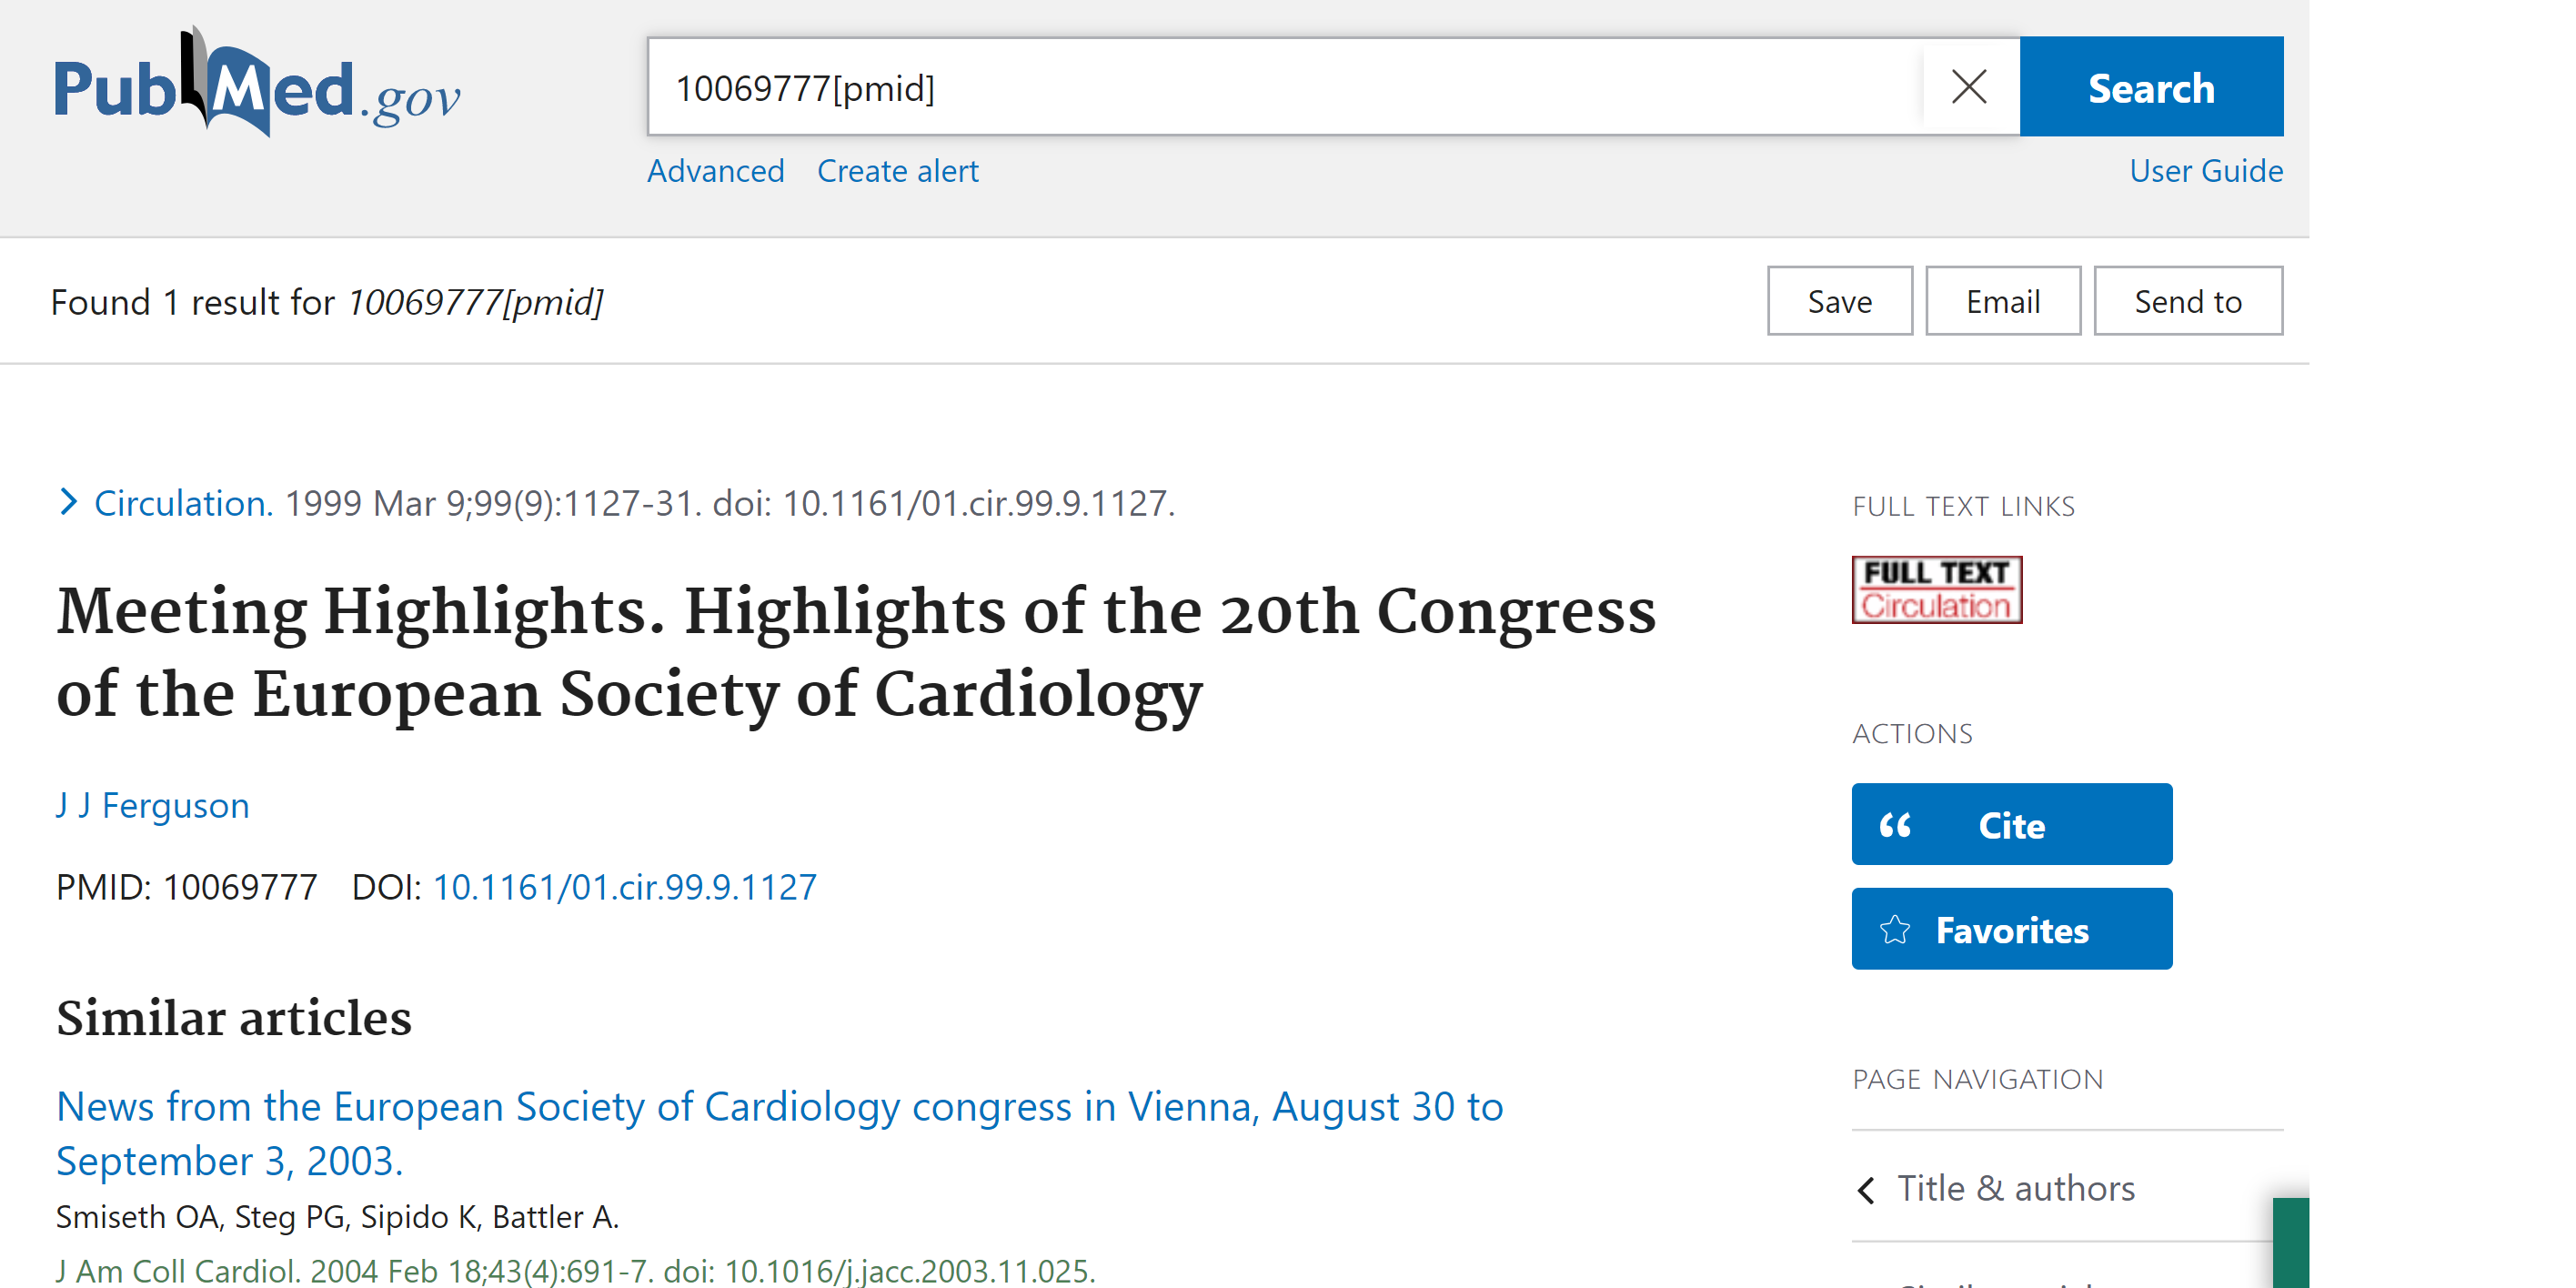

You can locate rows and columns with specific values using a `loc` command.  
Let's find a row corresponding to the PMID 8041685

In [ ]:
df.loc[df['pmid']=='8041685']

We can find rows whose topic is 'BetaBlockers' and triage decision is 'include' but their abstract information is not available.  

In [ ]:
df.loc[(df['topic']=='BetaBlockers') & (df['decision']=='I') & (df['abstract']=='NaN')]


When you take a close look at the data, you will notice that there are some articles whose 'decision' codes are integers

In [ ]:
df.loc[(df['topic']=='BetaBlockers') & (df['decision']=='5')].head()

According to the description of dataset (https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html), the integer codes indicate reasons for exclusion. Therefore, we can categorize those integer codes to 'E' in the 'decision column.  
  
Here, I would like to convert all "E's" to a numerical value 0 and "I's" to 1. Numerical annotations will allow us to perform predictive analysis at the later part of the module with ease.  
  
`replace(self,to_replace)` function replaces `self` values with `to_replace` values in a DataFrame.

In [ ]:
df['decision'] = df['decision'].replace(['1','2','3','4','5','6','7','8','9','E'], 0)
df['decision'] = df['decision'].replace('I', 1)

df.head(20)

We, now, have a neatly formatted dataset of articles, and you can quickly check the total number of  articles with the following code.

In [ ]:
df.topic.value_counts()

-------------
**Preprocessing Raw Text**  
  
Here, I will build a function that will preprocess the raw text of abstract using the functions we had built in a previous module.

If you have not installed `nltk` library, execute the code below

In [ ]:
# Run this cell only if you are installing nltk for the first time
pip install nltk 

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') 
stopword_list.remove('not') 

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    s = " "
    t_l = []
    t_w = nltk.word_tokenize(text)
    for w in t_w:
        l_w = wordnet_lemmatizer.lemmatize(w, pos="v")
        t_l.append(l_w)
    text = s.join(t_l)
    return text

Let’s now bring everything we learnt together and chain these operations to build a text normalizer to pre-process text data.

In [ ]:
def normalize_corpus(corpus, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

Let's put this function in action!. We will create a new column 'clean_abs' to hold pre-processed text of abstract.

In [ ]:
df['clean_abs'] = normalize_corpus(df['abstract'])
norm_corpus = list(df['clean_abs'])

df.head()

In the clean_abs column, all the text is in lowercase and there are also no punctuation marks, no stopwords, and no contractions. Our text cleaning has worked like a charm.  

Let's take a look at the first row of 'abstract' and 'clean_abs' columns and transform them in a dictionary form.

In [ ]:
# to_dict() function transforms row dataframe into a dictionary
df.iloc[0][['abstract','clean_abs']].to_dict()

In [ ]:
df.iloc[5679][['abstract','clean_abs']].to_dict()

We will use a dataset that does not have 'NaN' in the 'cleaned_abs' column.

In [ ]:
# Delete rows whose abstract texts are absent
droprow = df['abstract'].isin(['NaN']) # .isin() function searches rows that contain the argument
df= df[~droprow] # '~' means 'without'
df.reset_index(drop=True, inplace=True)

df.head(20)

You can export the final DataFrame 'df' to a csv named 'epc-ir_clean_10k' file using `to_csv()` function.  
(The cell below will bot be executed at this time)

If you want to download the preprocessed data file "epc-ir_clean_10k.csv" on your laptop or computer, please visit my GitHub   
https://github.com/eunsuk-c/Text_Mining

# Distribution of Target Class  

**Please run the code cell below to reveal the video.**

In [ ]:
HTML('<iframe width="705" height="537" src="https://edpuzzle.com/embed/media/5ec597ede885383efc905618" frameborder="0" allowfullscreen></iframe>')

**Loading dataset as a DataFrame**  
  
Let's take a look at our dataset, a DataFrame "df."  
Here, the included articles were marked 1's and excluded articles were marked 0's in the 'decision' column.

In [ ]:
import pandas as pd

# Our dataset is "df," a DataFrame imported from a csv file.
df = pd.read_csv('epc-ir_clean_10k.csv', index_col = 'index') 
df.head(10) # shows the first 10 rows of the DataFrame "df."
# The total number of instances after removing rows whose abstract texts are absent is 9078 (1+9077).

**Class distribution of 'decision'**

In [ ]:
'''
The output from a groupby and aggregation operation varies between Pandas Series and Pandas Dataframes,
which can be confusing for new users. As a rule of thumb, 
if you calculate more than one column of results, your result will be a Dataframe. 
For a single column of results, the agg function, by default, will produce a Series.
'''

# groupby(axis) function splits the data according to the axis.
# agg({axis:operator}) function aggregates values by axis and returns results calculated by operator
e_i = df.groupby('decision').agg({'decision':'count'})
e_i

**Visualizing the table by bar chart**  
  
(The numerical figures in this chart will be slightly different from the one in the video because we built the bar chart below from the dataset that excluded the articles with no abstract, whereas the bar chart in the video was built upon the dataset that included articles with no abstract.)

In [ ]:
import matplotlib.pyplot as plt

bars = plt.bar(range(2),e_i.decision,color='gr')
plt.xticks([0,1])
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width() / 2, h,str(h)+' (%.2f%%)' % (h/len(df)*100) , ha='center', va='bottom')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Word Frequencies

**Please run the code cell below to reveal the video.** 

In [ ]:
HTML('<iframe width="705" height="537" src="https://edpuzzle.com/embed/media/5ec5bbd929a6663f0d162bf2" frameborder="0" allowfullscreen></iframe>')

**Functions you will use for examining word frequencies in uni-, bi-, and trigrams**

In [ ]:
import nltk
from nltk.probability import FreqDist
from nltk.util import ngrams
import seaborn as sns

# The "function freq_unigram()"" counts words in unigram form and presents top 20 unigrams 
# in a horizontal bar graph.

def freq_unigram(x, terms = 20): 
    agg_words = ' '.join([text for text in x]) 
    all_words = agg_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 30 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

# The function "freq_bigram()"" counts words in bigram form and presents top 20 bigrams 
# in a horizontal bar graph.

def freq_bigram(x, terms = 20): 
    agg_words = ' '.join([text for text in x]) 
    unigrams = agg_words.split() 
    bigrams = ngrams(unigrams, 2)
    all_words = [' '.join(two_words) for two_words in bigrams]
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 30 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

# The function freq_trigram() counts words in trigram form and presents top 20 trigrams 
# in a horizontal bar graph.

def freq_trigram(x, terms = 20): 
    agg_words = ' '.join([text for text in x]) 
    unigrams = agg_words.split() 
    trigrams = ngrams(unigrams, 3)
    all_words = [' '.join(three_words) for three_words in trigrams]
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 30 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

**Sample execution of the functions**

Check word frequency in unigram in the entire dataset.

In [ ]:
# Word frequencies in unigram
freq_unigram(df.clean_abs) # same as freq_unigram(df['clean_abs'])

Check 20 most frequent bigrams in the entire dataset

In [ ]:
# Word frequencies in bigram
freq_bigram(df.clean_abs)

Check top 20 bigram features in the "ACEInhibitors" topic

In [ ]:
# Bigram frequencies: in "ACEInhibitors" topic
freq_bigram(df.clean_abs.loc[(df['topic']=='ACEInhibitors')])

Check top 20 trigram features in the "Atypical Antipsychotics" topic

In [ ]:
# Bigram frequencies: in "Atypical Antipsychotics" topic
freq_trigram(df.clean_abs.loc[(df['topic']=='AtypicalAntipsychotics')])

Check 20 most frequent bigrams in the articles included for the "BetaBlockers" topic.

In [ ]:
# Bigram frequencies: in articles included for the "Betablockers" topic
freq_bigram(df.clean_abs.loc[(df['topic']=='BetaBlockers') & (df['decision']==1)])

## Exercise (Word Frequencies) 

**Warning**  
<font color = blue, size = 4> 
    Your work will not be saved in Jupyter Notebook. You are recommended to copy your work and paste it to a safe place to record your work.
<font>

Using the `freq_unigram()` function and the DataFrame `df`, compare the word frequency in unigram between the **included** articles and **excluded** articles for the systematic review of **ADHD**. Can you notice any difference in word frequency between them?

**Suggested Answer**

In [ ]:
freq_unigram(df.clean_abs.loc[(df['decision']==1) & (df['topic']=='ADHD')])

In [ ]:
freq_unigram(df.clean_abs.loc[(df['decision']==0) & (df['topic']=='ADHD')])